# Experiment with Pytorch
to create endocder decoder ocr model with cnn and lstm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Setup path in .env file
import os
from dotenv import load_dotenv
import cv2
import numpy as np
import torch

# Get absolut path to proeject root
load_dotenv()
project_root_dir = os.path.dirname(os.path.abspath("./"))
print("Project root dir:", project_root_dir)

data_dir = os.getenv("PUBTABNET_CROPPED_DATA_DIR")
absolute_dir = project_root_dir + data_dir
print("Absolute path:", absolute_dir)

Project root dir: /Users/I518302/Library/CloudStorage/OneDrive-SAPSE/SAPDevelop/University/Seq2Seq/neural_networks_seminar
Absolute path: /Users/I518302/Library/CloudStorage/OneDrive-SAPSE/SAPDevelop/University/Seq2Seq/neural_networks_seminar/PubTabNet_cropped


In [5]:
image_dir_train = f"{absolute_dir}/train"
image_dir_val = f"{absolute_dir}/val"
label_file_train = f"{absolute_dir}/PubTabNet_2.0.0_train_separated.json"
label_file_val = f"{absolute_dir}/PubTabNet_2.0.0_val_separated.json"

In [6]:
import sys
sys.path.append('../')
from torch.utils.data import DataLoader
label_file_small = f"{absolute_dir}/subset_small.json"


In [7]:
# label_file_train = f"{absolute_dir}/PubTabNet_2.0.0_train.json"
# label_file_val = f"{absolute_dir}/PubTabNet_2.0.0_val.json"

# # Function to generate labels
# import json
# def generate_labels(json_data):
#     labels = []
#     for key, value in json_data.items():
#         cells = value["html"]["cells"]
#         for i, cell in enumerate(cells):
#             bbox = cell.get('bbox')
#             tokens = cell.get('tokens')
#             if bbox is None:
#                 continue
#             label = key.replace(".png", f"_bbox_{bbox[0]}_{bbox[1]}_{bbox[2]}_{bbox[3]}.png")
#             label = {
#                 "filename": key.replace(".png", f"_bbox_{bbox[0]}_{bbox[1]}_{bbox[2]}_{bbox[3]}.png"),
#                 "split": value["split"],
#                 "imgid": value["imgid"],
#                 "tokens": tokens,
#                 "bbox": bbox,
#             }
#             labels.append(label)
#     return labels

# # Generate labels
# with open(label_file_val, 'r') as f:
#         labels = json.load(f)
#         result = generate_labels(labels)

# # Specify the output file name
# output_file_name = f"{absolute_dir}/PubTabNet_2.0.0_val_separated.json"

# # Write the generated labels to a new JSON file
# with open(output_file_name, 'w') as output_file:
#     json.dump(result, output_file, indent=4)

# print(f"Generated labels have been written to {output_file_name}")

In [8]:
from torchvision import transforms
transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))]
transform = transforms.Compose(transform_list)

In [9]:
# Example usage:
from custom_ocr_cnn_lstm.dataset import OCRDataset
from custom_ocr_cnn_lstm.dataset_cropped import OCRDatasetCropped

train_dataset = OCRDatasetCropped(label_file_train, image_dir_train, transform=transform)
val_dataset = OCRDatasetCropped(label_file_val, image_dir_val, transform=transform)

# Accessing a sample
sample = train_dataset[0]
print(sample)

{'idx': 0, 'label': 'Species', 'image': tensor([[[ 1.0000,  0.9451,  0.5765,  0.7569,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  0.9294,  0.8902,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000],
         [ 1.0000,  0.0196,  0.9686,  0.5922,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  0.8824,  0.8353,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000],
         [ 1.0000, -0.2941,  0.8353,  1.0000,  0.8980,  0.5765,  0.3961,
           0.7412,  1.0000,  0.8039,  0.5529,  0.9608,  0.9294,  0.4745,
           0.6392,  0.7490,  0.7804,  1.0000,  0.7020,  0.6078,  1.0000,
           0.7020,  0.5608,  1.0000],
         [ 1.0000,  0.6235, -0.3804,  0.4588,  0.7804, -0.2000,  0.6157,
          -0.2706,  0.8980,  0.0118,  0.3490,  0.3725,  0.1765,  0.9765,
           0.6863,  0.4275,  0.4039,  0.560

In [10]:
max_height = 0
max_width = 0

for item in train_dataset:
    image = item['image']
    height, width = image.shape[1], image.shape[2]
    max_height = max(max_height, height)
    max_width = max(max_width, width)

print(f"Maximum Height: {max_height}")
print(f"Maximum Width: {max_width}")


Maximum Height: 84
Maximum Width: 429


In [11]:
# class SynthCollator(object):
    
#     def __call__(self, batch):
#         width = [item['image'].shape[2] for item in batch]
#         indexes = [item['idx'] for item in batch]
#         imgs = torch.ones([len(batch), batch[0]['image'].shape[0], batch[0]['image'].shape[1], 
#                            max(width)], dtype=torch.float32)
#         for idx, item in enumerate(batch):
#             try:
#                 imgs[idx, :, :, 0:item['image'].shape[2]] = item['image']
#             except:
#                 continue
#                 #print(imgs.shape)
#         item = {'image': imgs, 'idx':indexes}
#         if 'label' in batch[0].keys():
#             labels = [item['label'] for item in batch]
#             item['label'] = labels
#         return item

import torch
import torch.nn.functional as F

class CustomCollator(object):
    
    def __init__(self, target_height = max_height, target_width= max_width):
        self.target_height = target_height
        self.target_width = target_width
    
    def __call__(self, batch):
        indexes = [item['idx'] for item in batch]
        
        # Resize images to the target size
        resized_images = []
        for item in batch:
            image = item['image']
            resized_image = F.interpolate(image.unsqueeze(0), size=(self.target_height, self.target_width), mode='bilinear', align_corners=False)
            resized_images.append(resized_image.squeeze(0))
        
        # Stack resized images
        imgs = torch.stack(resized_images, dim=0)
        
        item = {'image': imgs, 'idx': indexes}
        
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        
        return item


In [45]:
# Example usage:
from custom_ocr_cnn_lstm.dataset import OCRDataset
from custom_ocr_cnn_lstm.dataset_cropped import OCRDatasetCropped

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=CustomCollator())
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True, collate_fn=CustomCollator())

In [13]:
# Vielleicht liegt der Fehler hier. 
# Batch enthält jeweils 3 items die dann 10 elemente jeweils enthalten
for batch_idx, samples in enumerate(train_loader):
    print("------")
    print(samples["image"].shape)
    print(batch_idx, samples["image"][0], samples["label"][0])
    break

------
torch.Size([10, 1, 84, 429])
0 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) 1


In [14]:
import re
def remove_xml_tags(input_string):
    pattern = r'<[^>]+>'
    return re.sub(pattern, '', input_string)

In [15]:
import json
def create_alphabet_file(alphabet, file_path):
    with open(file_path, 'w') as f:
        # f.write("START\n")
        for char in alphabet:
            f.write(char + "\n")
        # f.write("END\n")

# Replace these with your actual ground truth labels
train_labels = train_dataset.labels
val_labels = train_dataset.labels
# Concat both dicts
labels = train_labels + val_labels

alph_labels = []
for label in labels:
    label_tokens = label.get('tokens')
    label = " ".join(" ".join(tokens) for tokens in label_tokens)
    label = remove_xml_tags(label)
    alph_labels.append(label)
print("Ground truth labels loaded: ", len(alph_labels), alph_labels[:100])

unique_chars = set()
unique_radicals = set()

# Loop through ground truth labels to extract unique characters and radicals
for label in alph_labels:
    for char in label:
        unique_chars.add(char)
        # You might need to extract radicals from each character here if using decomposition

# Define the file paths for character and radical alphabets
char_alphabet_file_path = f"{absolute_dir}/character_alphabet.txt"
radical_alphabet_file_path = f"{absolute_dir}/radical_alphabet.txt"

# Create character alphabet file
create_alphabet_file(unique_chars, char_alphabet_file_path)
print(f"Character alphabet file created at: {char_alphabet_file_path}")

# Create radical alphabet file (if needed)
# create_alphabet_file(unique_radicals, radical_alphabet_file_path)
# print(f"Radical alphabet file created at: {radical_alphabet_file_path}")

Ground truth labels loaded:  13690 [' S p e c i e s ', ' A n a j a ́ s ', ' P o r t e l ', ' S S B V ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' W i l d ', ' R u r a l ', ' U r b a n ', ' T o t a l ', ' ( % ) ', ' E v a n d r o m y i a   w a l k e r i ', '4 4', '4 0', '1', '1 5 6', '2 9 6', '1', '5 1', '1', '2', '5 9 2', '6 8 . 8 4', ' E v a n d r o m y i a   i n f r a s p i n o s a ', '4 4', '0', '3', '8 2', '1', '0', '0', '0', '0', '1 3 0', '1 5 . 1 2', ' N y s s o m y i a   a n t u n e s i  a  ', '1 1', '3', '3', '2 0', '3', '0', '1', '0', '0', '4 1', '4 . 7 7', ' M i c r o p y g o m y i a   r o r o t a e n s i s ', '2 0', '1', '0', '4', '0', '0', '2', '0', '0', '2 7', '3 . 1 4', ' S c i o p e m y i a   s o r d e l l i i ', '7', '1', '0', '1 3', '2', '0', '2', '0', '0', '2 5', '2 . 9 1', ' B i c h r o m o m y i a   f l a v i s c u t e l l a t a  a  ', '0', '0', '0', '4', '0', '0', '1 6', '0', '0', '2 0', '2 . 3 2', ' N y s s o m y i a  

https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html#the-ctc-loss

In [16]:
# Load alpabet from file
def load_alphabet(file_path):
    with open(file_path, 'r') as f:
        alphabet = f.read().splitlines()
    return alphabet

alphabet = load_alphabet(char_alphabet_file_path)
print("Alphabet loaded:", len(alphabet), alphabet)

Alphabet loaded: 111 ['’', "'", 'S', '—', 'i', '×', '§', 'k', '′', '3', 'e', 'γ', '†', 'a', 'x', '/', '<', ' ', '%', 'Q', '0', 'A', ':', 'u', '°', 'G', '⁄', 'p', '>', 'Z', ']', 'w', 'E', 'L', 'c', 'N', 'y', 'α', 'b', '9', 'β', 'X', 'P', 's', '2', '7', 'q', '“', 'm', '(', '-', '−', 'r', 'W', '?', '5', '≤', 'j', '=', 'Y', 'o', '_', 'μ', '‐', 'h', 'f', '→', '·', 'B', 'C', ';', 'z', 't', 'H', 'n', 'O', ')', 'v', '4', '8', '≥', '`', '.', 'F', 'g', '&', 'K', ',', 'd', '6', '1', 'Δ', 'l', '”', 'V', '±', '#', '́', '+', 'R', 'I', 'J', '–', '*', 'M', 'D', '[', 'U', '$', 'λ', 'T']


In [17]:
def find_maximum_width(dataset):
    # Initialize a list to store image widths
    image_widths = []

    # Iterate through the dataset and collect image widths
    for sample in dataset:
        image_width = sample['image'].shape[2]  # Get the width of the image
        image_widths.append(image_width)

    # Find the maximum width across all images
    max_width = max(image_widths)

    return max_width

# Example usage:
max_width_train = find_maximum_width(train_dataset)
max_width_val = find_maximum_width(val_dataset)

max_width = max(max_width_train, max_width_val)

print("Maximum width in dataset:", max_width)


Maximum width in dataset: 454


In [18]:
# Setup environment for training
import numpy as np
from collections import OrderedDict
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from utils import OCRLabelConverter
from tqdm import *
from cnn_lstm_ocr import CNNLSTM_OCR

# params = {
#     "input_dim": 256,
#     "hidden_dim": 256,
#     "output_dim": 1,
#     "input_planes": 1,
#     "planes": 1,
#     "schedule": False,
#     'image_height':32,
#     'number_channels':1,
#     'number_hidden_layers':256,
#     'len_alphabet':len(alphabet),
#     'learning_rate':0.001,
#     'epochs':4,
#     'batch_size':10,
#     'model_dir':'model_history',
#     'log_dir':'logs',
#     'resume':False,
#     'cuda':False,
#     'schedule':False    
# }


params = {
    "input_dim": 1,  # Assuming grayscale images
    "alphabet": alphabet,
    "hidden_dim": 256,
    "output_dim": len(alphabet) + 1,  # Number of classes (including a blank symbol)
    "input_planes": 1,  # Assuming grayscale images
    "planes": 32,  # Adjust this value as needed
    'image_height': 32,  # Adjust as needed
    'number_channels': 1,  # Assuming grayscale images
    'number_hidden_layers': 2,  # Adjust as needed
    'len_alphabet': len(alphabet),  # Number of classes (excluding a blank symbol)
    'learning_rate': 0.001,
    'epochs': 4,
    'batch_size': 10,
    'model_dir': 'model_history',
    'log_dir': 'logs',
    'resume': False,
    'cuda': False,
    'schedule': False,
    'max_width': max_width
}



model = CNNLSTM_OCR(params)
converter = OCRLabelConverter(''.join(params['alphabet']))
criterion = CustomCTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=params['epochs'])
batch_size = params['batch_size']
count = 1
epochs = params['epochs']
cuda = params['cuda']
print("Params:", params)

def train_dataloader():
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader

NameError: name 'CustomCTCLoss' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from custom_ocr_cnn_lstm.cnn_lstm_ocr import CNNLSTM_OCR


# Define your model, criterion, optimizer, and other parameters here

# Initialize your model, criterion, and optimizer
model = CNNLSTM_OCR(params)  # Assuming you've already defined CNNLSTM_OCR class
# criterion = nn.CTCLoss()
criterion = CustomCTCLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=params['epochs'])

# Define training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        inputs = batch['image'].to(device)
        targets = batch['label']
        # print(targets)
        targets, lengths = converter.encode(targets)
        print("len targets: ", len(targets))
        # print(targets, lengths)

        optimizer.zero_grad()
        # print("cnn input inputs.shape:", inputs.shape)
        outputs = model(inputs)
        outputs = outputs.contiguous().cpu()
        outputs = torch.nn.functional.log_softmax(outputs, 2)
        # b is batch size, T is input sequence and h is hidden size
        b, T, h = outputs.size()
        print("outputs shape:", outputs)
        # print("targets shape:", targets.size())
        pred_sizes = torch.LongTensor([T for i in range(b)])
        print("pred_sizes shape:", pred_sizes)
        # Calculate the CTC loss
        # output_lengths = torch.full(size=(inputs.size(0),), fill_value=outputs.size(0), dtype=torch.long)
        print(outputs.shape, targets.shape, pred_sizes, lengths)
        print(len(pred_sizes), len(lengths), len(targets), len(outputs))
        loss = criterion(outputs, targets, pred_sizes, lengths)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Define validation method
# def validate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0.0

#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Validation"):
#             inputs = batch['image'].to(device)
#             targets = batch['label']
#             # Assuming targets need to be converted to tensor, e.g., using a function `text_to_tensor`
#             targets = text_to_tensor(targets) 

#             outputs = model(inputs)
            
#             # Calculate the CTC loss
#             output_lengths = torch.full(size=(inputs.size(0),), fill_value=outputs.size(0), dtype=torch.long)
#             loss = criterion(outputs, targets, input_lengths=None, target_lengths=output_lengths)
            
#             total_loss += loss.item()

#     return total_loss / len(dataloader)

# Training loop
device = torch.device("cuda" if params['cuda'] and torch.cuda.is_available() else "cpu")
model.to(device)
train_dataloader = train_loader  # Assuming you have train_loader defined
val_dataloader = val_loader  # Assuming you have val_loader defined

for epoch in range(params['epochs']):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    # val_loss = validate(model, val_dataloader, criterion, device)
    scheduler.step()  # Adjust learning rate
    
    print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), params['model_dir'] + '/model.pth')


In [19]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from colorama import Fore
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [20]:
device = torch.device('cpu')

In [76]:
# ============================================= PREPARING DATASET ======================================================
epochs = 3
num_classes = len(alphabet)
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 29
cnn_output_width = 93
digits_per_sequence = 5
number_of_sequences = 10000
#emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
dataset_sequences = []
dataset_labels = []

""" 
for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28)))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)
 """

' \nfor i in range(number_of_sequences):\n    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))\n    random_digits_images = emnist_dataset.data[random_indices]\n    transformed_random_digits_images = []\n\n    for img in random_digits_images:\n        img = transforms.ToPILImage()(img)\n        img = TF.rotate(img, -90, fill=0)\n        img = TF.hflip(img)\n        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)\n        img = transforms.ToTensor()(img).numpy()\n        transformed_random_digits_images.append(img)\n\n    random_digits_images = np.array(transformed_random_digits_images)\n    random_digits_labels = emnist_dataset.targets[random_indices]\n    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28)))\n    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))\n    dataset_sequences.append(random_sequence / 255)\n    dataset_labels.append(r

In [77]:
import json
import os
from PIL import Image
from torchvision import transforms
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Assume pubtabnet_json contains the data in the format you provided
# Load the JSON data
with open('/Users/I518302/Library/CloudStorage/OneDrive-SAPSE/SAPDevelop/University/Seq2Seq/neural_networks_seminar/custom_ocr_cnn_lstm/PubTabNet_2.0.0_train_separated.json', 'r') as f:
    pubtabnet_data = json.load(f)

# Build a set of unique characters from the tokens in the PubTabNet data
unique_chars = set()
for entry in pubtabnet_data:
    unique_chars.update(entry['tokens'])
unique_chars = sorted(list(unique_chars))

# Create a mapping from characters to labels (including a blank label)
char_to_label = {char: i for i, char in enumerate(unique_chars)}
char_to_label['<blank>'] = len(unique_chars)
num_classes = len(unique_chars) + 1  # Number of classes including the blank label

# Define necessary parameters
image_height = 128  # Height of the input images (you may need to adjust this based on your specific case)
tokens_per_sequence = 5  # Number of tokens (characters) in each sequence
number_of_sequences = len(pubtabnet_data)  # Total number of sequences in the dataset

# Transformation to resize/crop the images
transform = transforms.Compose([
    transforms.Resize((image_height, image_height)),
    transforms.ToTensor()
])

dataset_sequences = []
dataset_labels = []

# Iterate through the PubTabNet data
for entry in pubtabnet_data:
    filename = entry['filename']
    bbox = entry['bbox']
    tokens = entry['tokens']

    # Load the image and apply the bounding box to crop
    img = Image.open(os.path.join('/Users/I518302/Library/CloudStorage/OneDrive-SAPSE/SAPDevelop/University/Seq2Seq/neural_networks_seminar/PubTabNet_cropped/train', filename))
    img_cropped = img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    img_tensor = transform(img_cropped)

    # Pad the image if needed to match the desired image_height
    if img_tensor.shape[1] < image_height:
        pad = torch.zeros((img_tensor.shape[0], image_height - img_tensor.shape[1], img_tensor.shape[2]))
        img_tensor = torch.cat((img_tensor, pad), dim=1)

    dataset_sequences.append(img_tensor)
    
    # Convert tokens to their respective labels
    labels = [char_to_label[char] for char in tokens]
    labels.extend([char_to_label['<blank>']] * (tokens_per_sequence - len(labels)))  # Pad with blank labels if necessary
    dataset_labels.append(labels)

# Pad sequences to a fixed length
def pad_sequence(sequence, max_length, padding_value):
    pad_len = max(0, max_length - len(sequence))
    return sequence + [padding_value] * pad_len

# Define the maximum sequence length (adjust as needed)
max_sequence_length = 470

# Iterate through the PubTabNet data and pad the sequences
padded_dataset_labels = []
for labels in dataset_labels:
    padded_labels = pad_sequence(labels, max_sequence_length, char_to_label['<blank>'])
    padded_dataset_labels.append(padded_labels)

# Convert to tensors
dataset_sequences = torch.stack(dataset_sequences) / 255.0
dataset_labels = torch.tensor(padded_dataset_labels)

# Create TensorDataset
seq_dataset = TensorDataset(dataset_sequences, dataset_labels)

# Split into train and validation sets (adjust the split ratio as needed)
train_set_size = int(0.8 * len(seq_dataset))
train_set, val_set = torch.utils.data.random_split(seq_dataset, [train_set_size, len(seq_dataset) - train_set_size])

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)


In [80]:
# ================================================= MODEL ==============================================================
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        
        out = out.permute(0, 3, 2, 1)
        # Calculate the correct value for the -1 dimension
        total_elements = out.numel()
        correct_value_for_minus_one = total_elements // (batch_size * self.gru_input_size)

        # Reshape with the correct value for -1
        out = out.reshape(batch_size, correct_value_for_minus_one, self.gru_input_size)
        # out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


model = CRNN().to(device)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [38]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        inputs = batch['image'].to(device)
        targets = batch['label']
        # print(targets)
        targets, lengths = converter.encode(targets)
        print("len targets: ", len(targets))
        # print(targets, lengths)

        optimizer.zero_grad()
        # print("cnn input inputs.shape:", inputs.shape)
        outputs = model(inputs)
        outputs = outputs.contiguous().cpu()
        outputs = torch.nn.functional.log_softmax(outputs, 2)
        # b is batch size, T is input sequence and h is hidden size
        b, T, h = outputs.size()
        print("outputs shape:", outputs)
        # print("targets shape:", targets.size())
        pred_sizes = torch.LongTensor([T for i in range(b)])
        print("pred_sizes shape:", pred_sizes)
        # Calculate the CTC loss
        # output_lengths = torch.full(size=(inputs.size(0),), fill_value=outputs.size(0), dtype=torch.long)
        print(outputs.shape, targets.shape, pred_sizes, lengths)
        print(len(pred_sizes), len(lengths), len(targets), len(outputs))
        loss = criterion(outputs, targets, pred_sizes, lengths)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [79]:
# Training loop
train_dataloader = train_loader  # Assuming you have train_loader defined
val_dataloader = val_loader  # Assuming you have val_loader defined

for epoch in range(3):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    # val_loss = validate(model, val_dataloader, criterion, device)
    scheduler.step()  # Adjust learning rate
    
    print(f"Epoch {epoch+1}/{params['epochs']} - Train Loss: {train_loss:.4f}")

# Save the trained model
#torch.save(model.state_dict(), params['model_dir'] + '/model.pth')

Training:   0%|          | 0/86 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not str

In [84]:
# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        # print("x_train_shape: ", x_train.shape)
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[2], -1)
        # print("x_train_shape: ", x_train.shape)

        optimizer.zero_grad()
        y_pred = model(x_train)
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
"""     val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], x_val.shape[3])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total) """

  0%|          | 0/86 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 5476 = 0.0


  0%|          | 0/86 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 5476 = 0.0


  0%|          | 0/86 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 5476 = 0.0


'     val_correct = 0\n    val_total = 0\n    for x_val, y_val in tqdm(val_loader,\n                             position=0, leave=True,\n                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):\n        batch_size = x_val.shape[0]\n        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], x_val.shape[3])\n        y_pred = model(x_val)\n        y_pred = y_pred.permute(1, 0, 2)\n        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)\n        target_lengths = torch.IntTensor([len(t) for t in y_val])\n        criterion(y_pred, y_val, input_lengths, target_lengths)\n        _, max_index = torch.max(y_pred, dim=2)\n        for i in range(batch_size):\n            raw_prediction = list(max_index[:, i].detach().cpu().numpy())\n            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])\n            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):\

actual:  [ 32  14  12  18  27 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121 121
 121 121 121 121 121 121 121 121 121 121 1

TypeError: Invalid shape (3, 128, 128) for image data

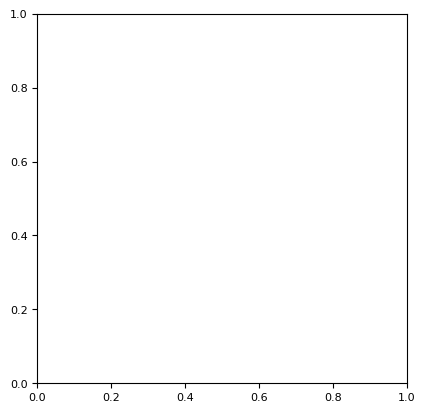

In [93]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 1
test_loader = train_loader # torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[2], -1))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    print("actual: ", str(y_test[j].numpy()))
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j].squeeze(), cmap='gray')
    mpl.rcParams["font.size"] = 18
    
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()